In [1]:
import numpy as np
import pandas as pd
import japanize_matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.chdir("../")

# 単語の一致率

In [2]:
RATE_A = "RateA"
RATE_S = "RateS"

df_yorushika = pd.read_csv("csv/ヨルシカ_20231119.csv")
df_greeeen = pd.read_csv("csv/GReeeeN_20231119.csv")

In [3]:
df_wmr_yorushika = pd.read_csv("csv/ヨルシカ_wmr_20231119.csv")
df_wmr_greeeen = pd.read_csv("csv/GReeeeN_wmr_20231119.csv")
word_matched_rates = pd.concat([pd.concat([df_yorushika, df_wmr_yorushika], axis=1), pd.concat([df_greeeen, df_wmr_greeeen], axis=1)], axis=0)
word_matched_rates = word_matched_rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

word_matched_rates[RATE_A] = word_matched_rates.numerator_A / word_matched_rates.denominator_A
word_matched_rates[RATE_S] = word_matched_rates.numerator_S / word_matched_rates.denominator_S

x_max_wmr = word_matched_rates.RateA.max()
x_min_wmr = word_matched_rates.RateA.min()
y_max_wmr = word_matched_rates.RateS.max()
y_min_wmr = word_matched_rates.RateS.min()

xy_max_wmr = max(x_max_wmr, y_max_wmr) + 0.05
xy_min_wmr = min(x_min_wmr, y_min_wmr) - 0.05

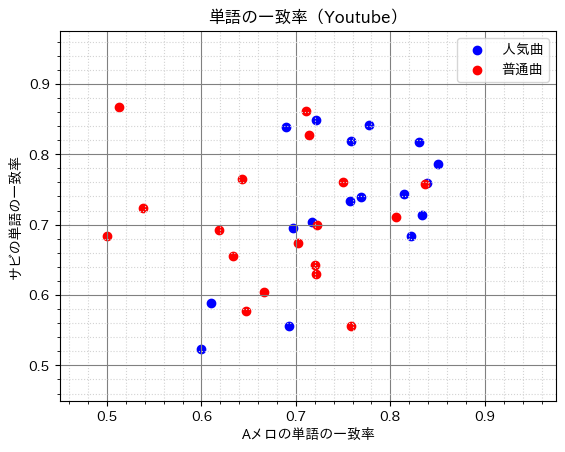

In [4]:
sort_by_youtube = word_matched_rates.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sort_by_youtube) // 2
pop_youtube = sort_by_youtube[:center]
unpop_youtube = sort_by_youtube[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

plt.title("単語の一致率（Youtube）")
plt.xlabel("Aメロの単語の一致率")
plt.ylabel("サビの単語の一致率")
plt.legend()
plt.xlim(xy_min_wmr, xy_max_wmr)
plt.ylim(xy_min_wmr, xy_max_wmr)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

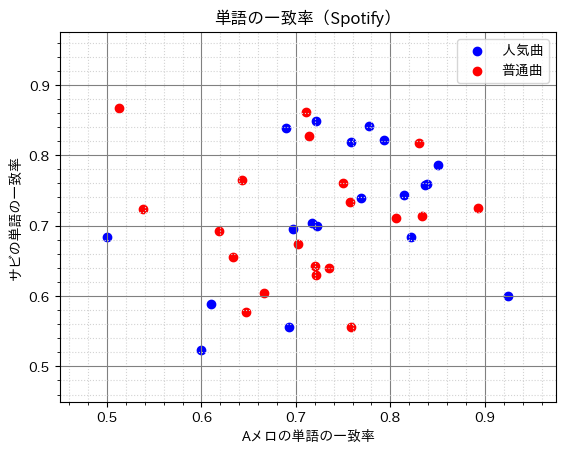

In [5]:
sort_by_spotify = word_matched_rates.dropna(subset=["spotify_id"]).sort_values("spotify_popularity", ascending=False)
center = len(sort_by_spotify) // 2
pop_spotify = sort_by_spotify[:center]
unpop_spotify = sort_by_spotify[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_spotify, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_spotify, color='red', label='普通曲')

plt.title("単語の一致率（Spotify）")
plt.xlabel("Aメロの単語の一致率")
plt.ylabel("サビの単語の一致率")
plt.legend()
plt.xlim(xy_min_wmr, xy_max_wmr)
plt.ylim(xy_min_wmr, xy_max_wmr)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 木構造の類似度（全部分木）

In [6]:
df_ts_yorushika = pd.read_csv("csv/ヨルシカ_ts_20231119.csv")
df_ts_greeeen = pd.read_csv("csv/GReeeeN_ts_20231119.csv")
tree_similarity = pd.concat([pd.concat([df_yorushika, df_ts_yorushika], axis=1), pd.concat([df_greeeen, df_ts_greeeen], axis=1)], axis=0)
tree_similarity = tree_similarity.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

tree_similarity[RATE_A] = tree_similarity.numerator_A / tree_similarity.denominator_A
tree_similarity[RATE_S] = tree_similarity.numerator_S / tree_similarity.denominator_S

x_max_ts = tree_similarity.RateA.max()
x_min_ts = tree_similarity.RateA.min()
y_max_ts = tree_similarity.RateS.max()
y_min_ts = tree_similarity.RateS.min()

xy_max_ts = max(x_max_ts, y_max_ts) + 0.01
xy_min_ts = min(x_min_ts, y_min_ts) - 0.01

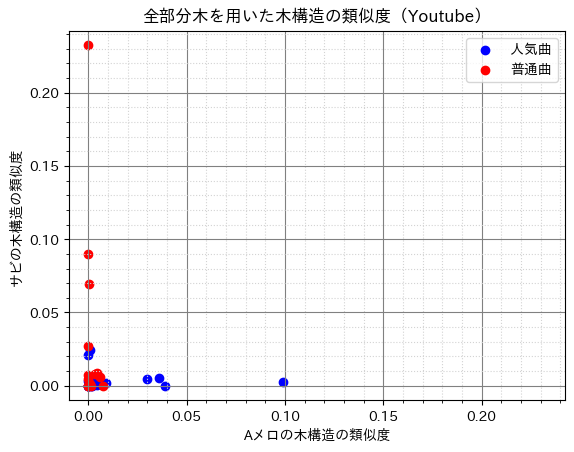

In [7]:
sort_by_youtube = tree_similarity.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center == len(sort_by_youtube) // 2
pop_youtube = sort_by_youtube[:center]
unpop_youtube = sort_by_youtube[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

plt.title("全部分木を用いた木構造の類似度（Youtube）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

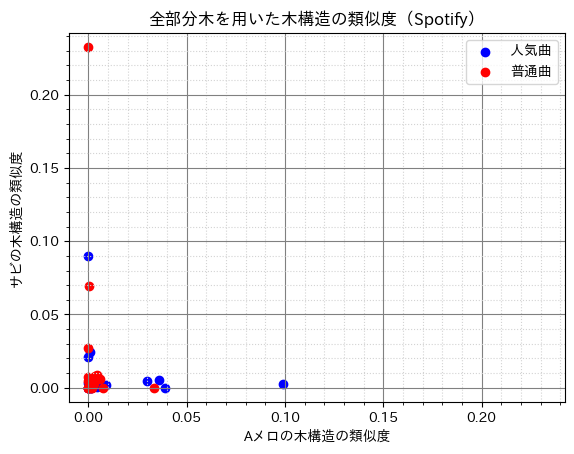

In [8]:
sort_by_spotify = tree_similarity.dropna(subset=["spotify_id"]).sort_values("spotify_popularity", ascending=False)
center = len(sort_by_spotify) // 2
pop_spotify = sort_by_spotify[:center]
unpop_spotify = sort_by_spotify[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_spotify, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_spotify, color='red', label='普通曲')

plt.title("全部分木を用いた木構造の類似度（Spotify）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 木構造の類似度計算（親子）

In [9]:
df_ts_yorushika = pd.read_csv("csv/ヨルシカ_tspc_20231119.csv")
df_ts_greeeen = pd.read_csv("csv/GReeeeN_tspc_20231119.csv")
tree_similarity = pd.concat([pd.concat([df_yorushika, df_ts_yorushika], axis=1), pd.concat([df_greeeen, df_ts_greeeen], axis=1)], axis=0)
tree_similarity = tree_similarity.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

tree_similarity[RATE_A] = tree_similarity.numerator_A / tree_similarity.denominator_A
tree_similarity[RATE_S] = tree_similarity.numerator_S / tree_similarity.denominator_S

x_max_ts = tree_similarity.RateA.max()
x_min_ts = tree_similarity.RateA.min()
y_max_ts = tree_similarity.RateS.max()
y_min_ts = tree_similarity.RateS.min()

xy_max_ts = max(x_max_ts, y_max_ts) + 0.01
xy_min_ts = min(x_min_ts, y_min_ts) - 0.01

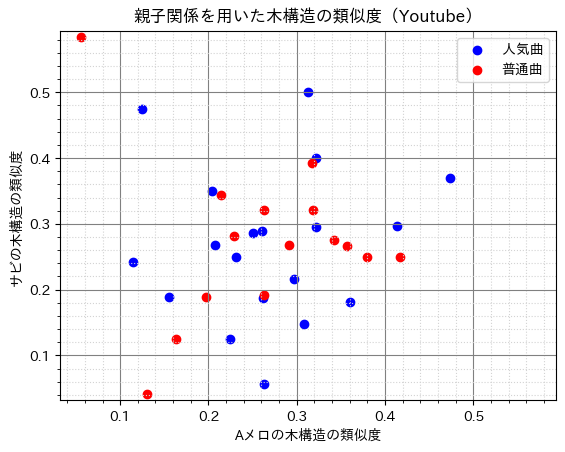

In [10]:
sort_by_youtube = tree_similarity.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center == len(sort_by_youtube) // 2
pop_youtube = sort_by_youtube[:center]
unpop_youtube = sort_by_youtube[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

plt.title("親子関係を用いた木構造の類似度（Youtube）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

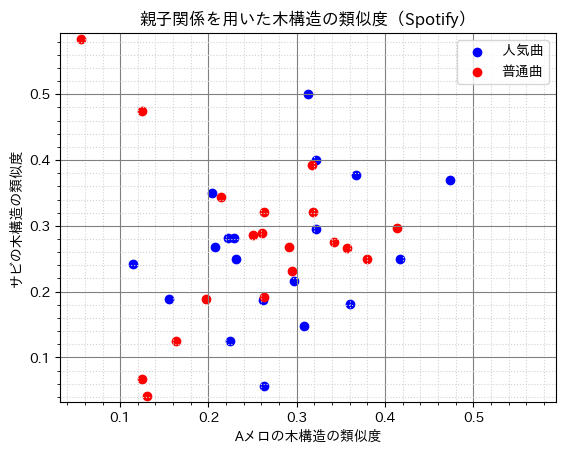

In [11]:
sort_by_spotify = tree_similarity.dropna(subset=["spotify_id"]).sort_values("spotify_popularity", ascending=False)
center = len(sort_by_spotify) // 2
pop_spotify = sort_by_spotify[:center]
unpop_spotify = sort_by_spotify[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_spotify, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_spotify, color='red', label='普通曲')

plt.title("親子関係を用いた木構造の類似度（Spotify）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 木構造の類似度計算（親子, w1）
$${
    w1 = \frac{
        height_a * height_b
    }{
        height_a + height_b
    }
}$$

In [12]:
df_ts_yorushika = pd.read_csv("csv/ヨルシカ_tspc_w1_20231119.csv")
df_ts_greeeen = pd.read_csv("csv/GReeeeN_tspc_w1_20231119.csv")
tree_similarity = pd.concat([pd.concat([df_yorushika, df_ts_yorushika], axis=1), pd.concat([df_greeeen, df_ts_greeeen], axis=1)], axis=0)
tree_similarity = tree_similarity.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

tree_similarity[RATE_A] = tree_similarity.numerator_A / tree_similarity.denominator_A
tree_similarity[RATE_S] = tree_similarity.numerator_S / tree_similarity.denominator_S

x_max_ts = tree_similarity.RateA.max()
x_min_ts = tree_similarity.RateA.min()
y_max_ts = tree_similarity.RateS.max()
y_min_ts = tree_similarity.RateS.min()

xy_max_ts = max(x_max_ts, y_max_ts) + 0.01
xy_min_ts = min(x_min_ts, y_min_ts) - 0.01

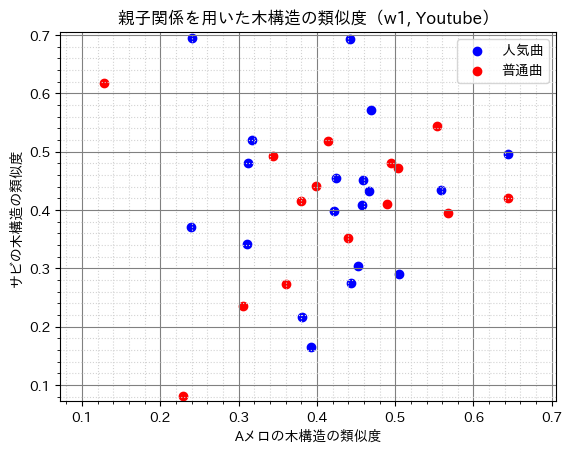

In [13]:
sort_by_youtube = tree_similarity.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center == len(sort_by_youtube) // 2
pop_youtube = sort_by_youtube[:center]
unpop_youtube = sort_by_youtube[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

plt.title("親子関係を用いた木構造の類似度（w1, Youtube）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')

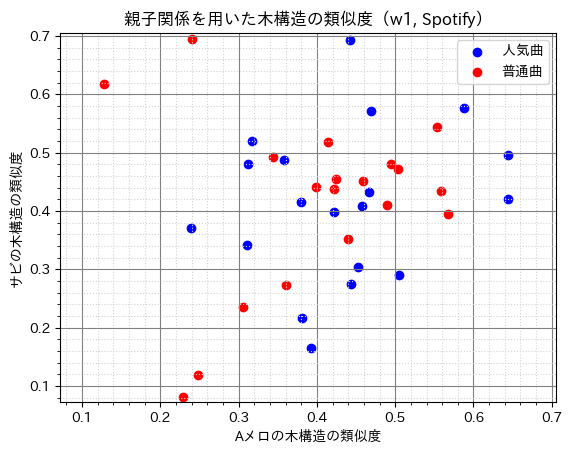

In [14]:
sort_by_spotify = tree_similarity.dropna(subset=["spotify_id"]).sort_values("spotify_popularity", ascending=False)
center = len(sort_by_spotify) // 2
pop_spotify = sort_by_spotify[:center]
unpop_spotify = sort_by_spotify[center:]

plt.scatter(x=RATE_A, y=RATE_S, data=pop_spotify, color='blue', label='人気曲')
plt.scatter(x=RATE_A, y=RATE_S, data=unpop_spotify, color='red', label='普通曲')

plt.title("親子関係を用いた木構造の類似度（w1, Spotify）")
plt.xlabel("Aメロの木構造の類似度")
plt.ylabel("サビの木構造の類似度")
plt.xlim(xy_min_ts, xy_max_ts)
plt.ylim(xy_min_ts, xy_max_ts)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='solid')
plt.grid(which='minor', color='lightgray', linestyle='dotted')